In [15]:
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as sstats
import scikit_posthocs as sp
import matplotlib.ticker as mticker
import os

In [16]:
plt.rcParams.update({'figure.facecolor': 'white'})
sns.set_style('whitegrid')

def load_summaries(csv_dirs):
    df_list = []
    for alg, pattern in csv_dirs.items():
        for fp in glob.glob(pattern):
            df = pd.read_csv(fp)
            df['algorithm'] = alg
            df_list.append(df)
    return pd.concat(df_list, ignore_index=True)

def load_histories(csv_dirs_hist):
    df_list = []
    for alg, pattern in csv_dirs_hist.items():
        for fp in glob.glob(pattern):
            df = pd.read_csv(fp)
            df['algorithm'] = alg
            df_list.append(df)
    return pd.concat(df_list, ignore_index=True)

csv_dirs = {
    'CMA_ES': 'CMA_ES_results_20250527_125054/CMA_ES_results.csv',
    'DE':     'DE_VariableDimensions_results_20250527_125928/DE_results.csv',
    'GA':     'GA_Variable_results_20250527_131116/GA_Variable_results.csv',
    'GE':     'GE_results_20250527_200128/GE_results.csv',
    'GP':     'GP_results_20250527_132707/GP_results.csv',
}

csv_dirs_hist = {
    'CMA_ES': 'CMA_ES_results_20250527_125054/CMA_ES_history.csv',
    'DE':     'DE_VariableDimensions_results_20250527_125928/DE_history.csv',
    'GA':     'GA_Variable_results_20250527_131116/GA_Variable_history.csv',
    'GE':     'GE_results_20250527_200128/GE_history.csv',
    'GP':     'GP_results_20250527_132707/GP_history.csv',
}

results = load_summaries(csv_dirs)
history = load_histories(csv_dirs_hist)

history = history.sort_values(
    by=['benchmark','algorithm','replicate','evals']
)

history['best_so_far'] = (
    history
    .groupby(['benchmark','algorithm','replicate'])['fitness']
    .cummin()
)

print(results.describe())
print(results.isna().sum())
results = results[np.isfinite(results['best'])]

target_map = {
    'Sphere':30,
    'Rastrigin':30,
    'Griewank':30,
    'Ackley':30,
    'Koza':10,
    'Knapsack':20,
    'Parity':64,
    'SantaFe':100
}

results = results[np.isfinite(results['best'])]
results['delta_len'] = results.apply(
    lambda r: abs(r['len_final'] - target_map[r['benchmark']]), axis=1
)

        replicate          seed        best   len_final        cpu_s
count  900.000000  9.000000e+02  900.000000  900.000000   900.000000
mean    14.500000  1.082326e+09  -50.852204   55.256667   346.766766
std      8.660254  6.258997e+08  156.731791   67.053195   965.833336
min      0.000000  6.106058e+06 -569.000000    3.000000     1.837900
25%      7.000000  5.462523e+08   -2.825000   27.750000    10.881225
50%     14.500000  1.093769e+09    0.004209   32.000000    29.165400
75%     22.000000  1.603804e+09    1.140622   66.000000   240.585800
max     29.000000  2.146668e+09   95.868915  568.000000  6725.203700
run_id       0
benchmark    0
replicate    0
seed         0
best         0
len_final    0
cpu_s        0
algorithm    0
dtype: int64


Results written: descriptive_stats.csv
    benchmark algorithm   best_mean  best_median   best_std     best_25  \
0      Ackley    CMA_ES    3.021107     0.000024  16.427833    0.000001   
1      Ackley        DE    0.093461     0.067923   0.082394    0.046240   
2      Ackley        GA    0.094488     0.085276   0.043781    0.058997   
3    Griewank    CMA_ES    4.334268     0.000000  16.543014    0.000000   
4    Griewank        DE    0.001875     0.000443   0.003328    0.000195   
5    Griewank        GA    0.000745     0.000543   0.000662    0.000306   
6    Knapsack    CMA_ES -472.100000  -473.000000  40.156891 -495.000000   
7    Knapsack        DE -508.000000  -508.000000   0.000000 -508.000000   
8    Knapsack        GA -569.000000  -569.000000   0.000000 -569.000000   
9        Koza    CMA_ES    8.402886     0.006428  21.814957    0.002607   
10       Koza        DE    4.189637     1.848936   7.009087    1.140622   
11       Koza        GA    0.032965     0.024597   0.026798  

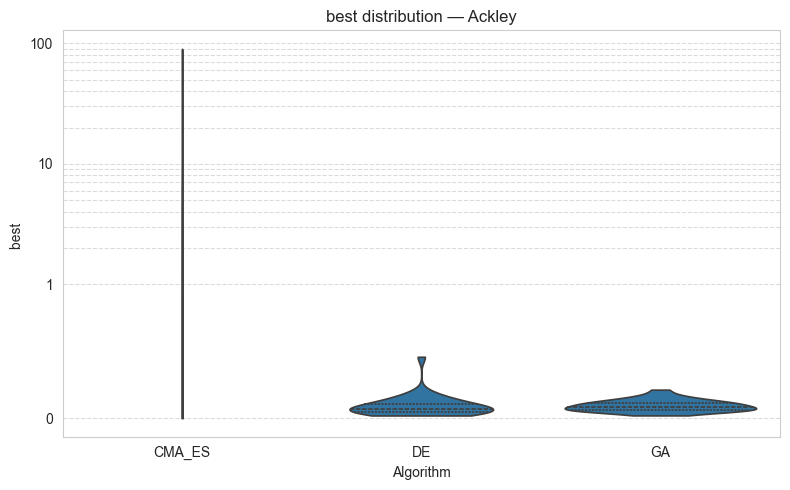

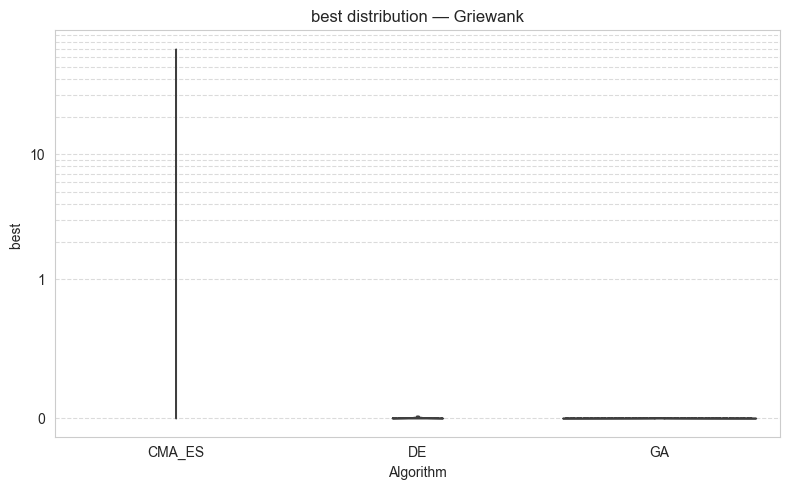

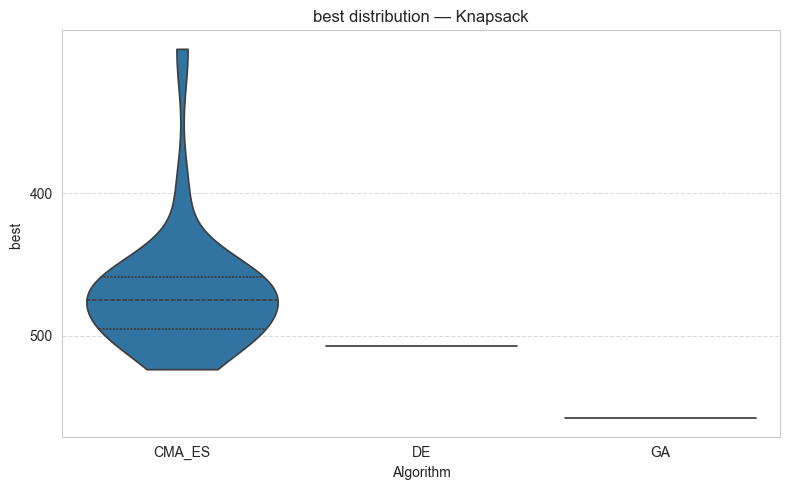

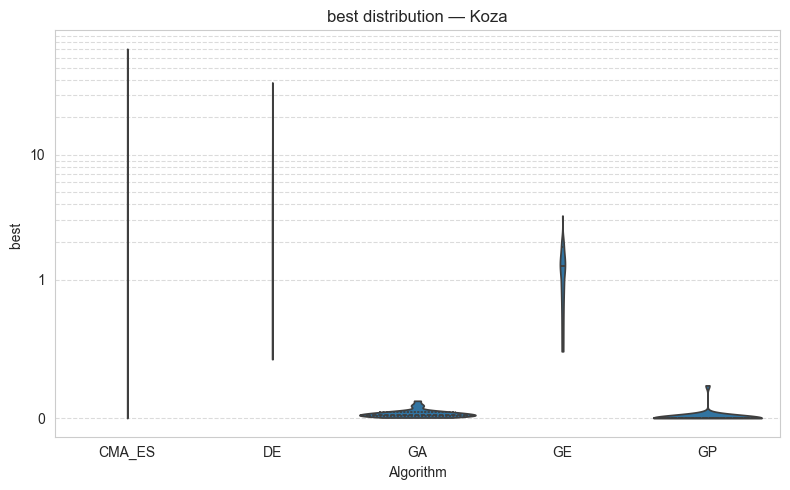

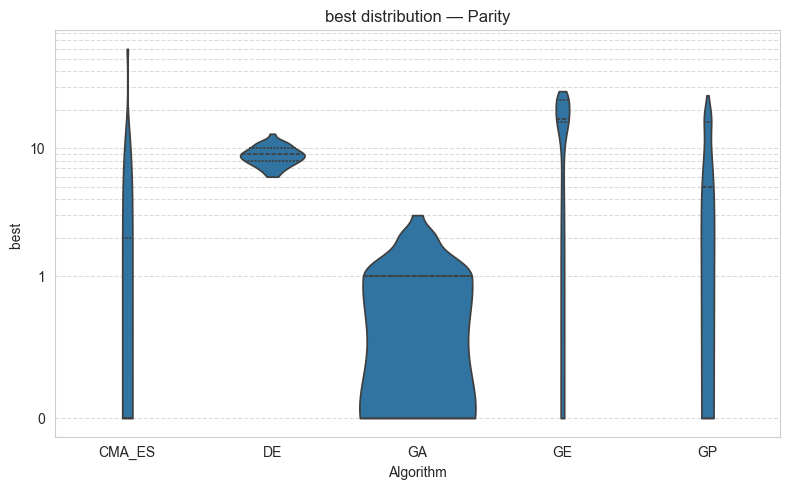

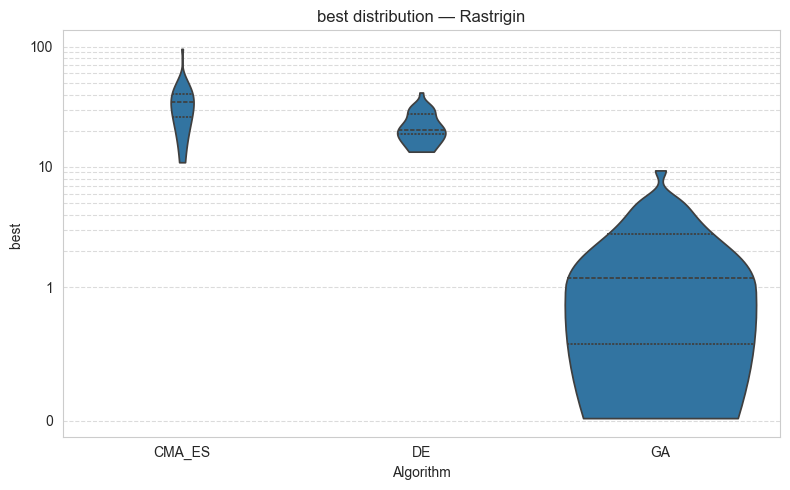

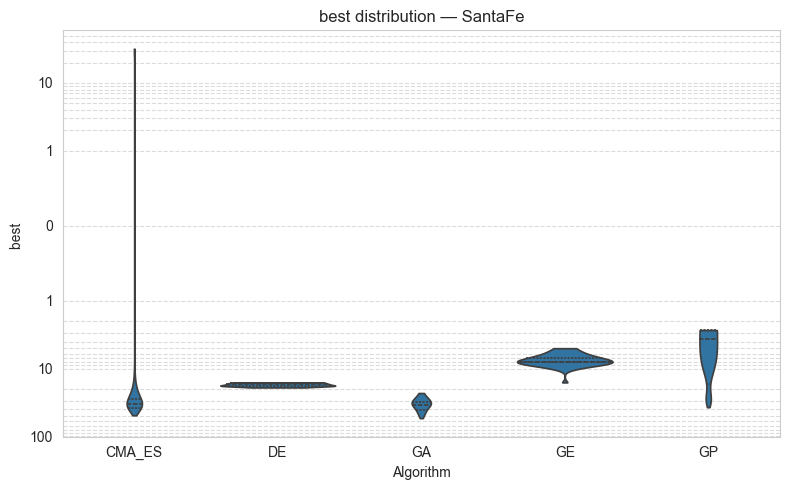

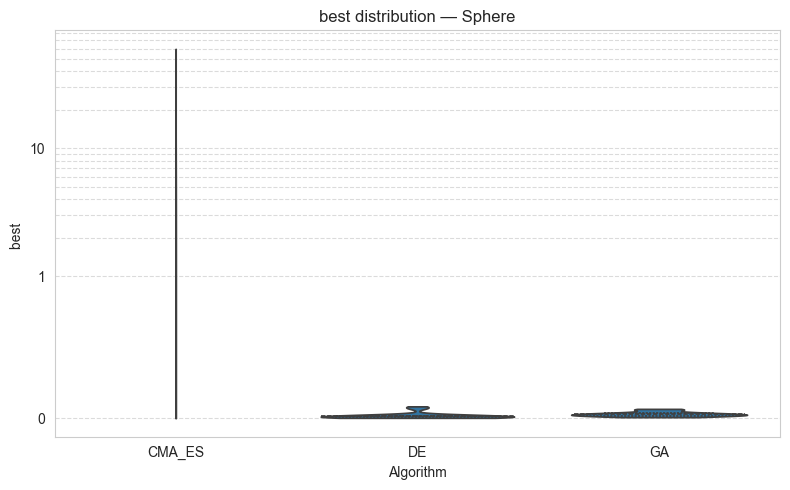

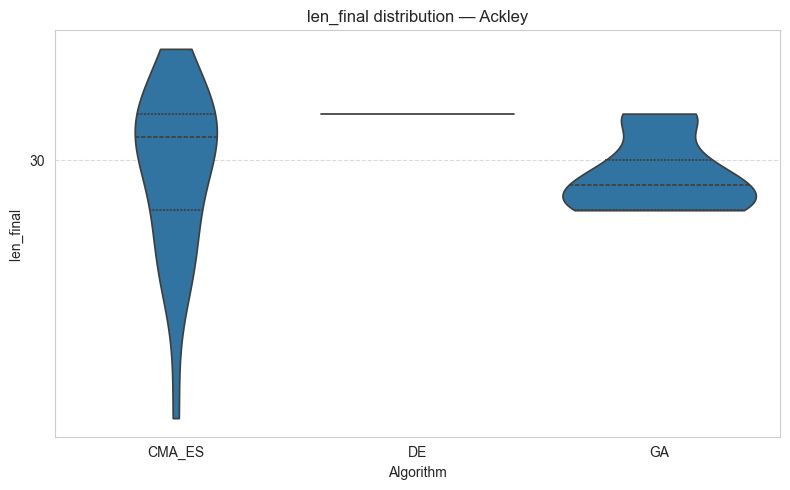

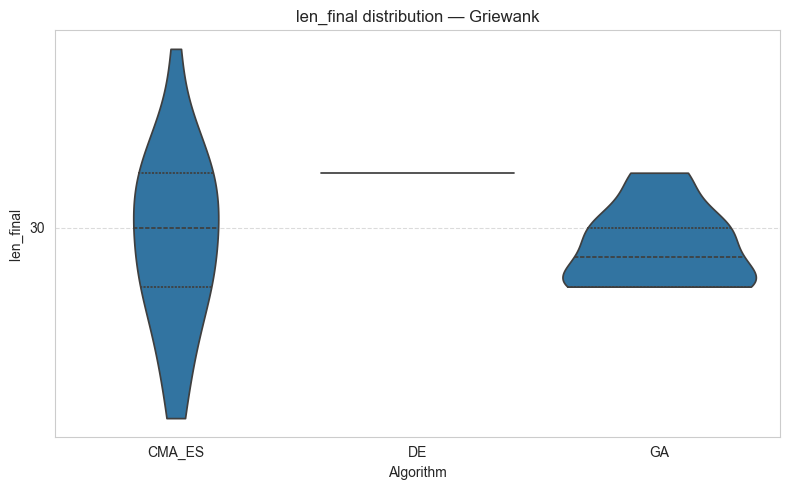

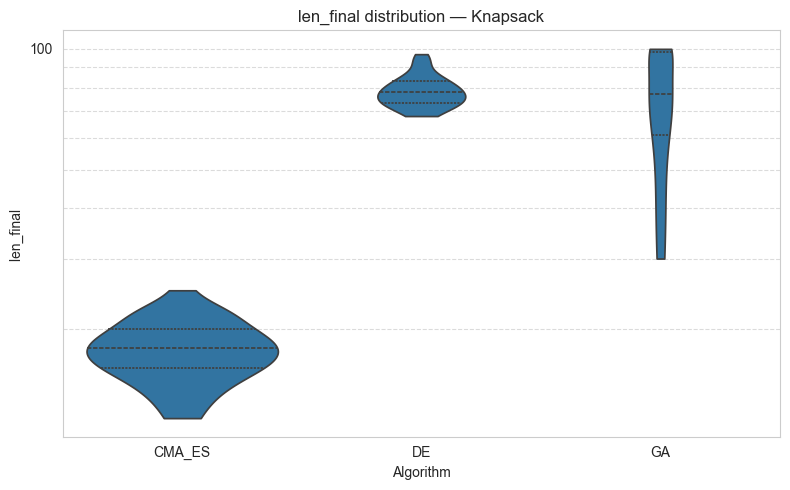

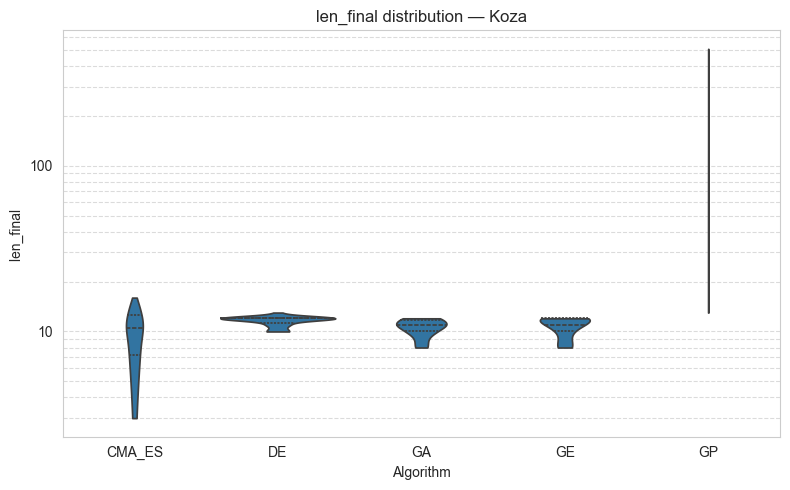

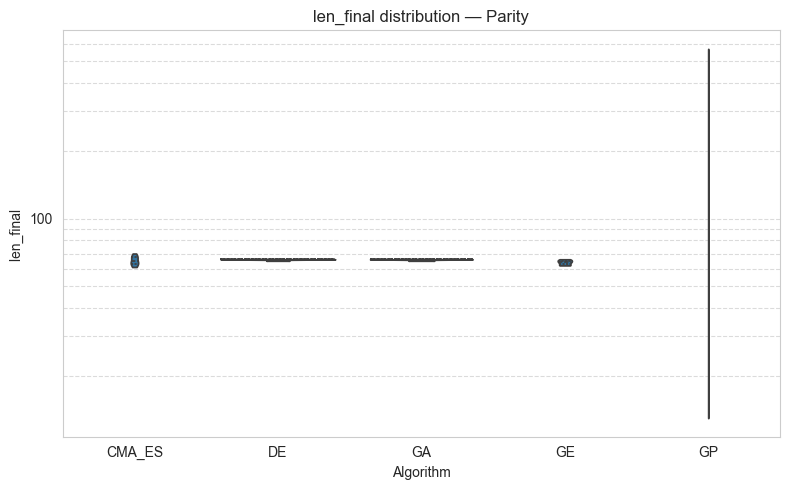

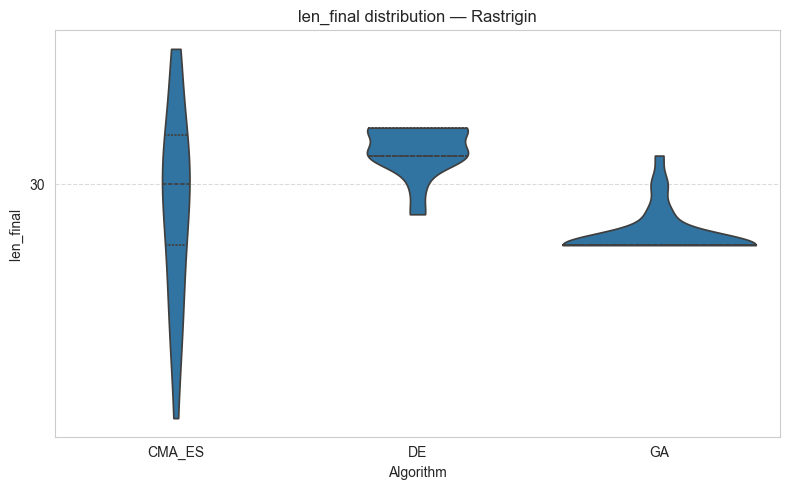

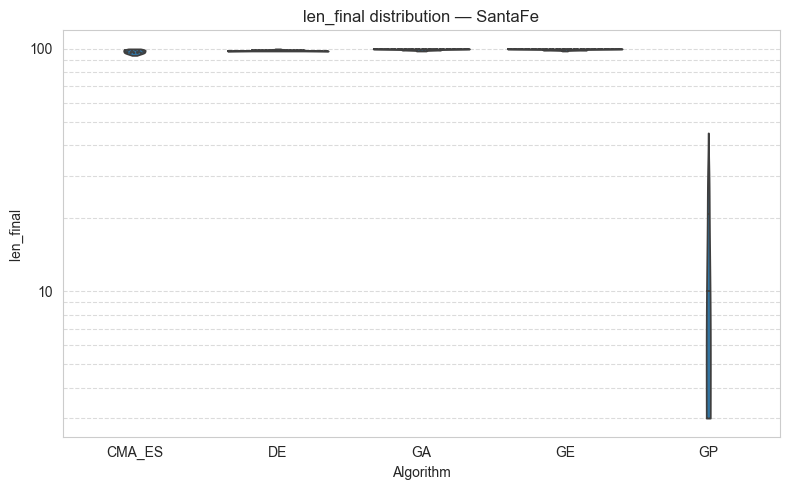

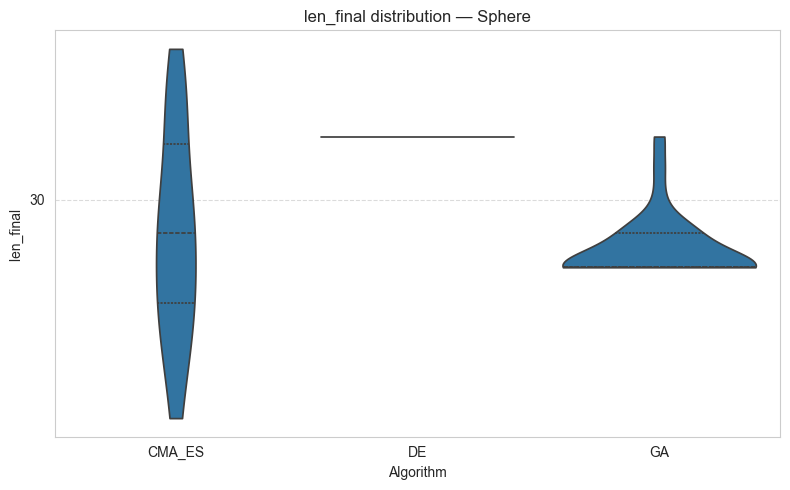

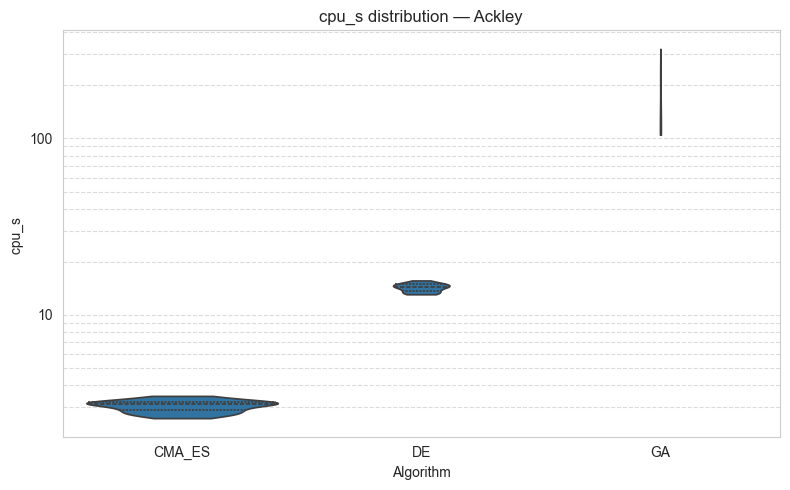

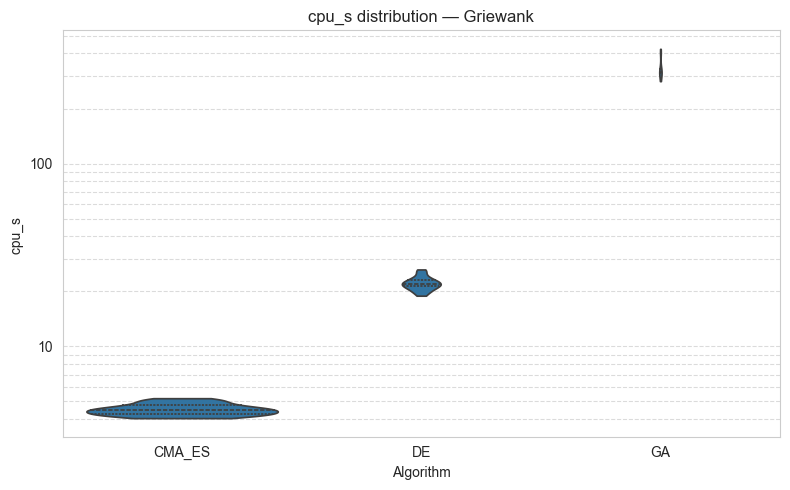

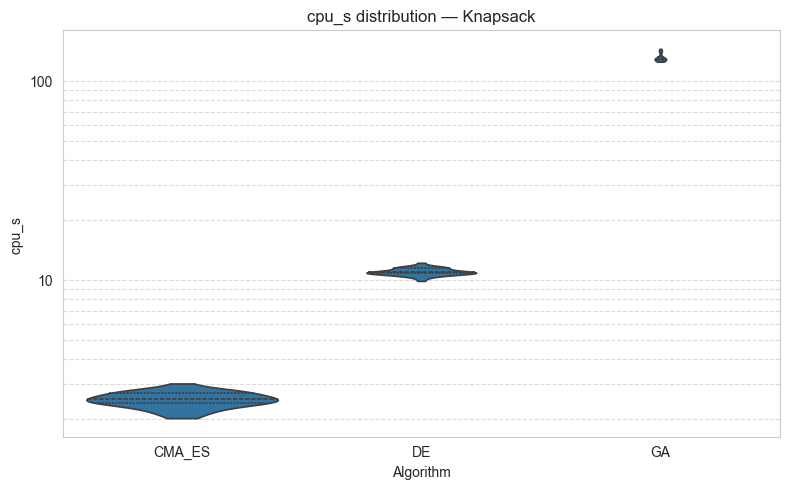

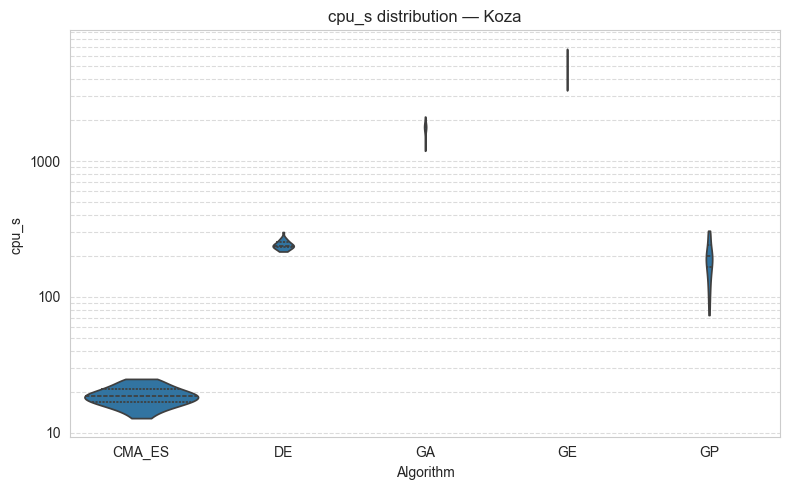

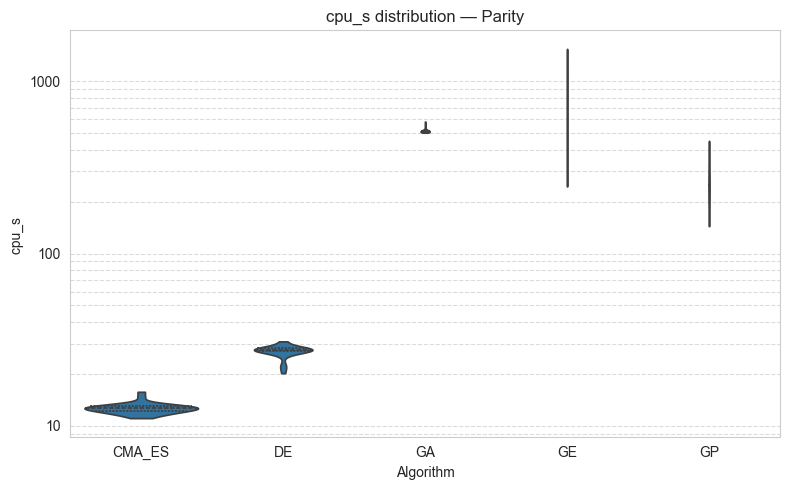

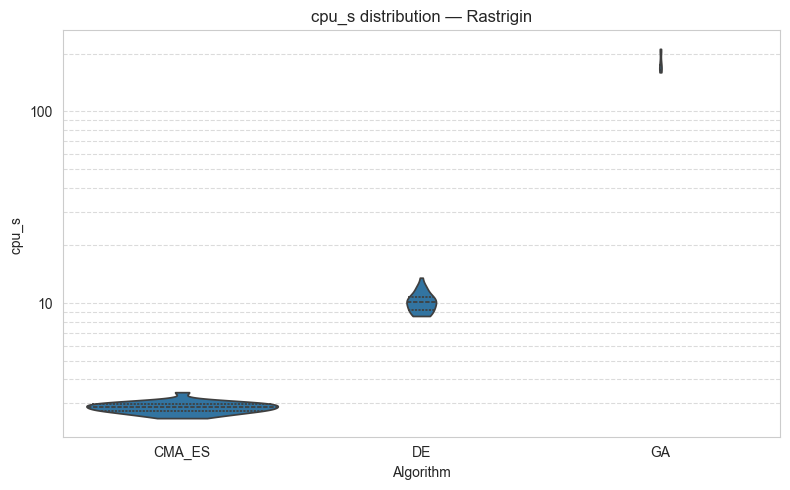

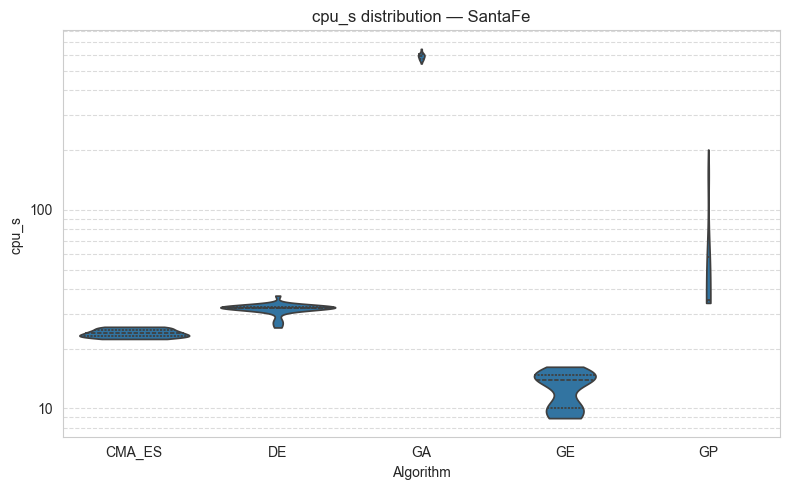

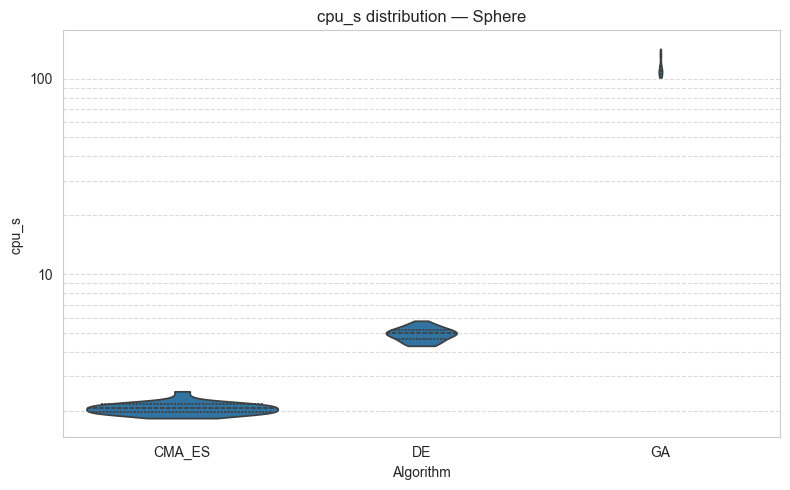

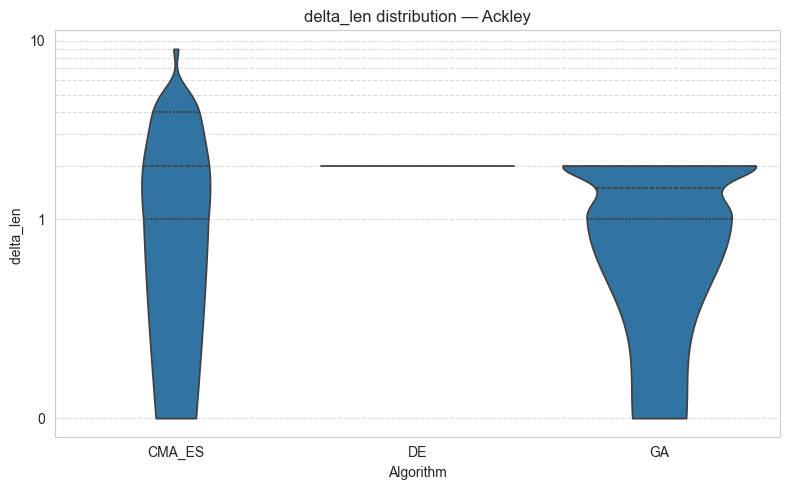

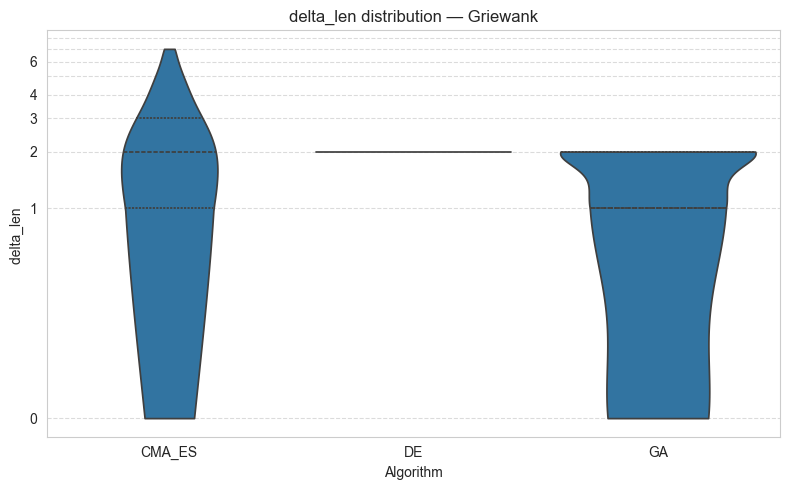

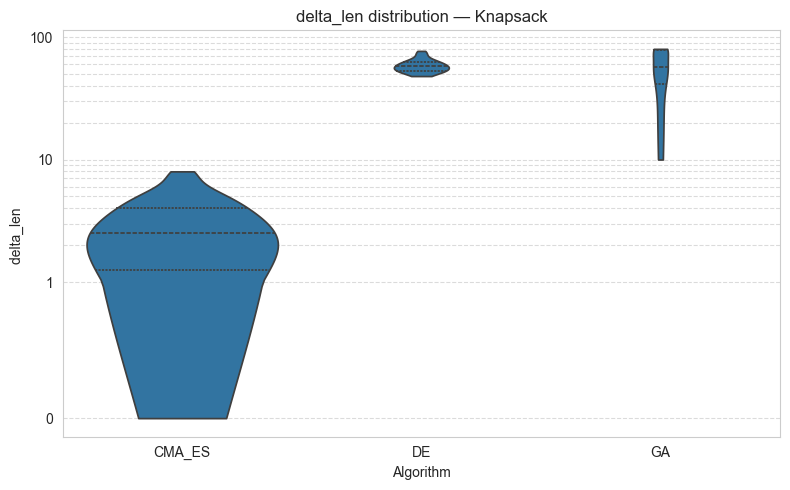

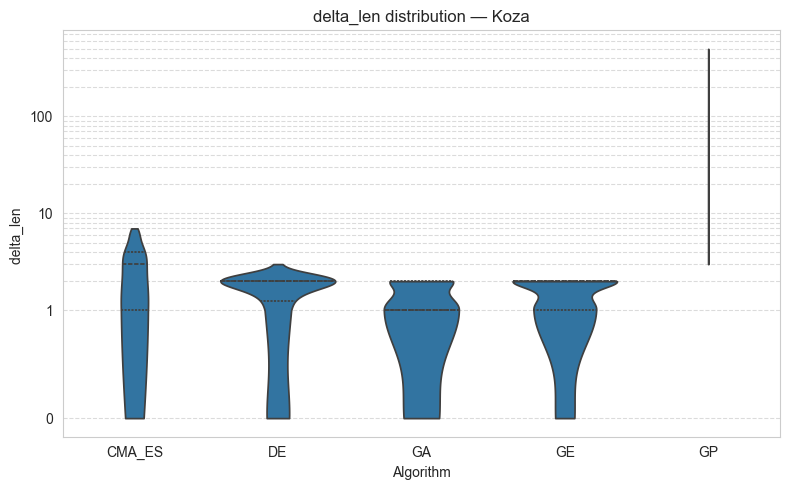

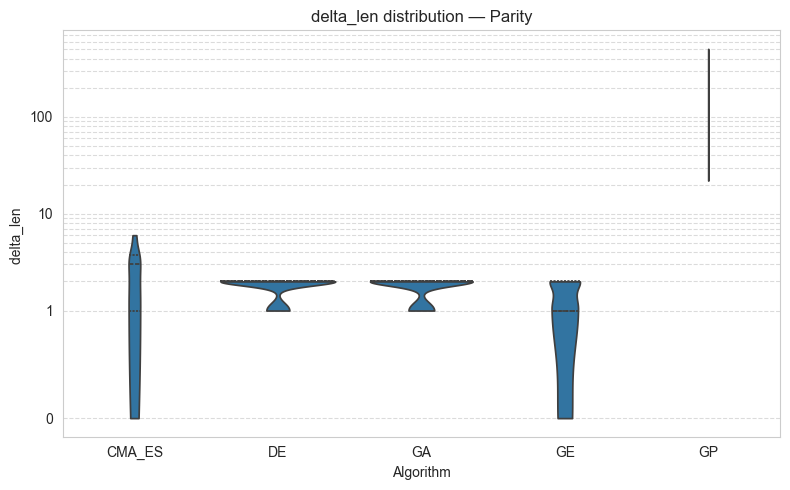

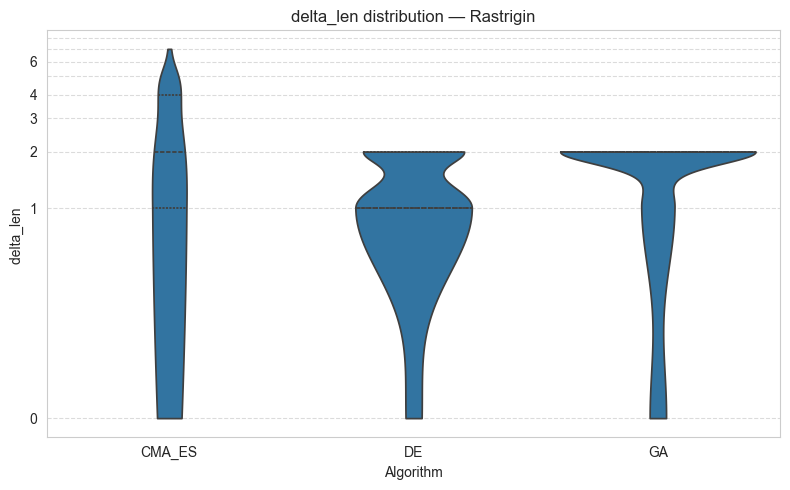

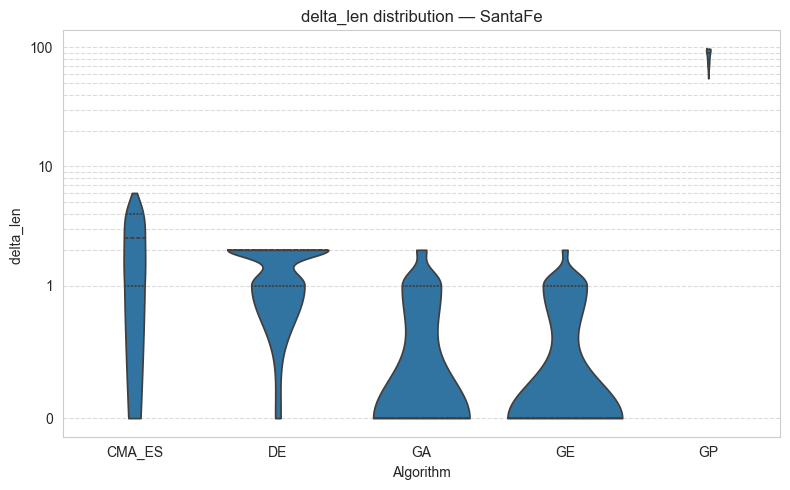

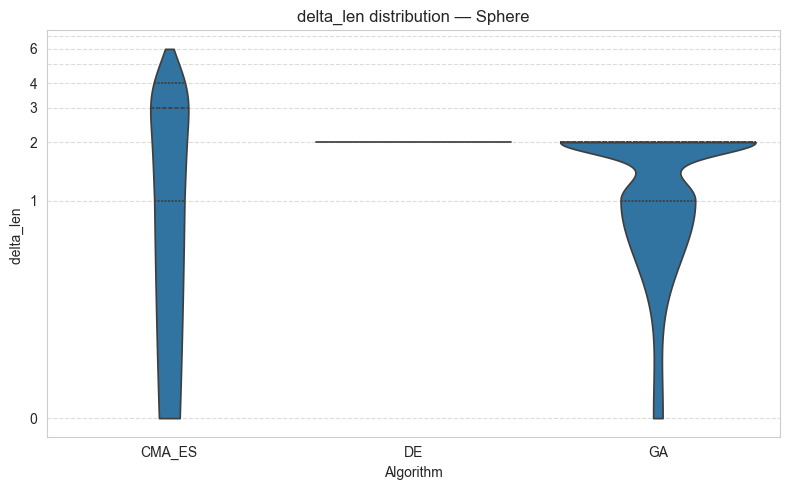

In [17]:
metrics = ['best', 'len_final', 'cpu_s', 'delta_len']

desc = results.groupby(['benchmark', 'algorithm']).agg(
    best_mean=('best', 'mean'),
    best_median=('best', 'median'),
    best_std=('best', 'std'),
    best_25=('best', lambda x: x.quantile(0.25)),
    best_75=('best', lambda x: x.quantile(0.75)),
    len_final_mean=('len_final', 'mean'),
    len_final_median=('len_final', 'median'),
    len_final_std=('len_final', 'std'),
    len_final_25=('len_final', lambda x: x.quantile(0.25)),
    len_final_75=('len_final', lambda x: x.quantile(0.75)),
    cpu_s_mean=('cpu_s', 'mean'),
    cpu_s_median=('cpu_s', 'median'),
    cpu_s_std=('cpu_s', 'std'),
    cpu_s_25=('cpu_s', lambda x: x.quantile(0.25)),
    cpu_s_75=('cpu_s', lambda x: x.quantile(0.75)),
    delta_len_mean=('delta_len', 'mean'),
    delta_len_median=('delta_len', 'median'),
    delta_len_std=('delta_len', 'std'),
    delta_len_25=('delta_len', lambda x: x.quantile(0.25)),
    delta_len_75=('delta_len', lambda x: x.quantile(0.75)),
).reset_index()

desc.to_csv('descriptive_stats.csv', index=False)
print('Results written: descriptive_stats.csv')
print(desc)

for m in metrics:
    for bench, sub in results.groupby('benchmark'):
        fig, ax = plt.subplots(figsize=(8,5), facecolor='white')
        ax.set_facecolor('white')
        sns.violinplot(x='algorithm', y=m, data=sub,
                       inner='quartile', cut=0, ax=ax)

        ax.set_yscale('symlog', linthresh=1, linscale=1)
        ax.yaxis.set_major_locator(
            mticker.SymmetricalLogLocator(
                base=10, linthresh=1, subs=np.arange(1, 10)
            )
        )
        ax.yaxis.set_major_formatter(
            mticker.LogFormatter(base=10.0, labelOnlyBase=False)
        )
        ax.yaxis.set_minor_locator(mticker.NullLocator())
        ax.yaxis.grid(True, which='major', linestyle='--', alpha=0.7)
        ax.set_axisbelow(True)
        ax.margins(y=0.05)

        plt.title(f'{m} distribution — {bench}')
        plt.xlabel('Algorithm')
        plt.ylabel(f'{m} ')
        plt.tight_layout()
        plt.show()

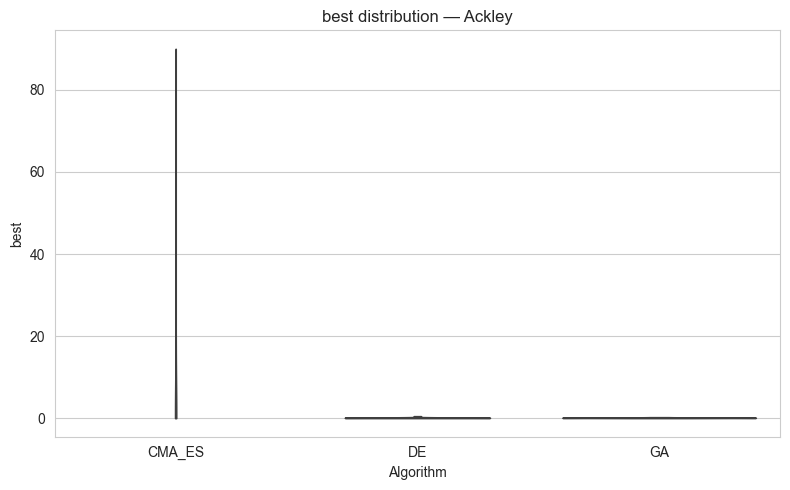

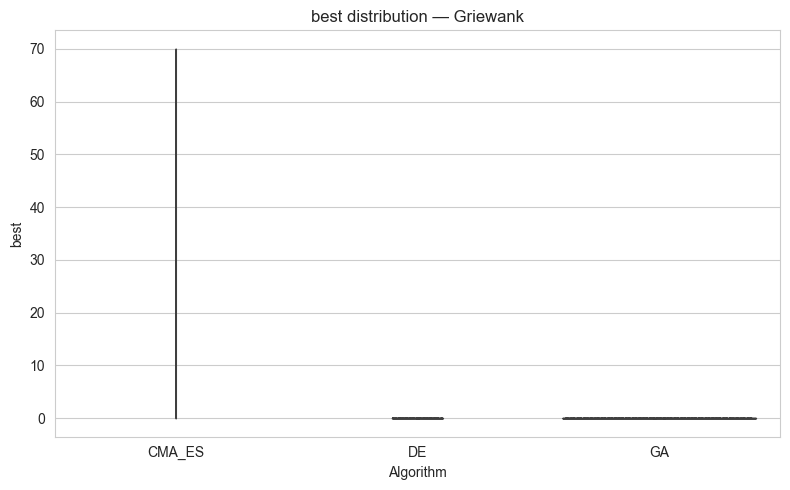

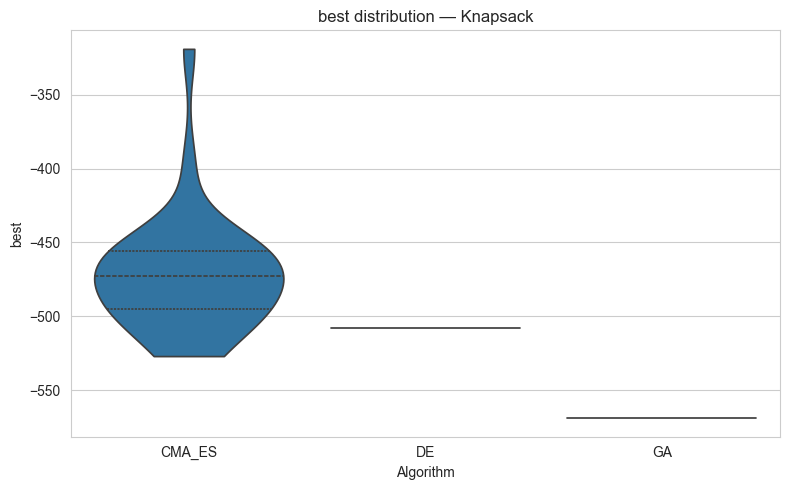

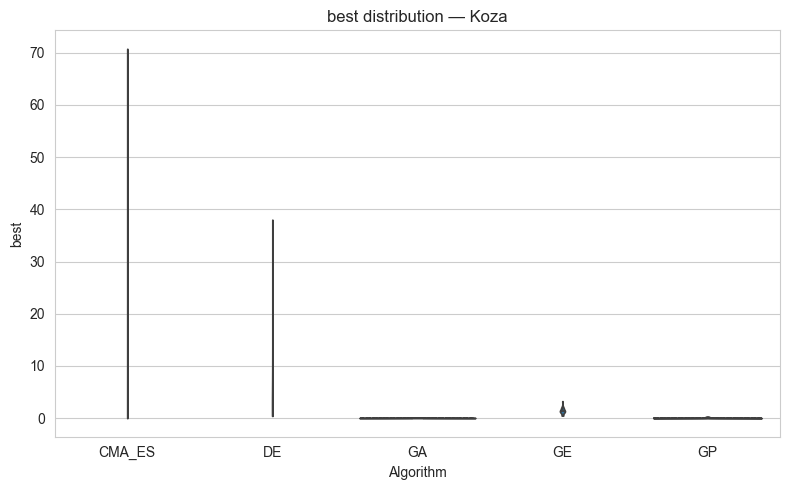

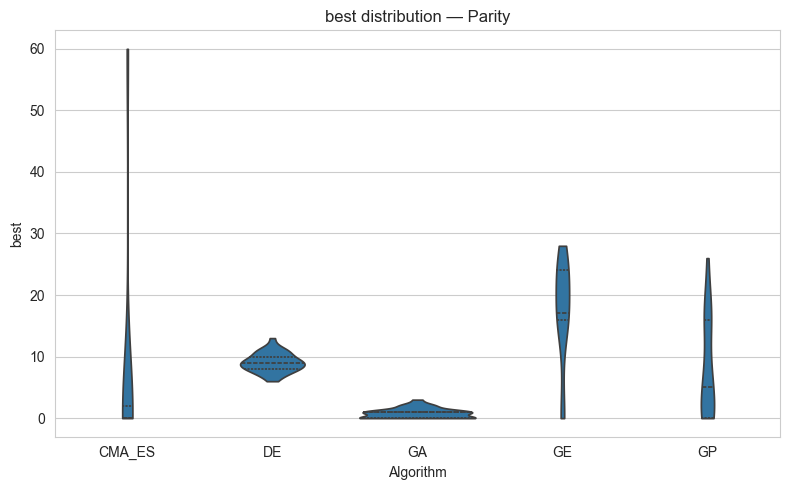

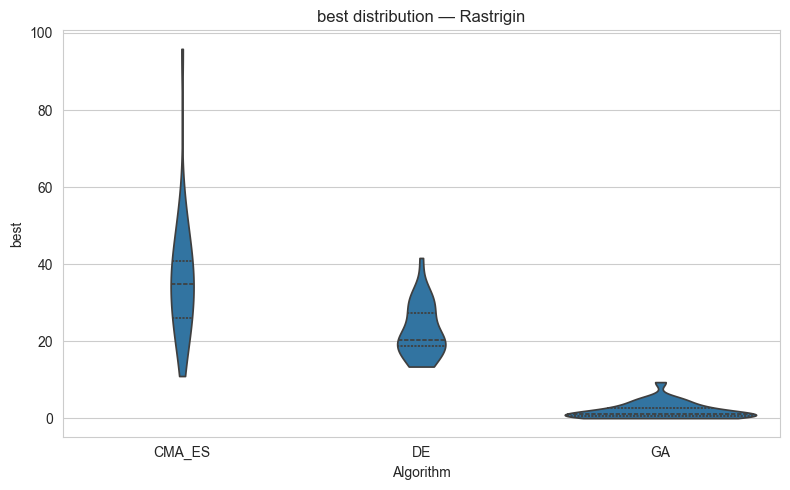

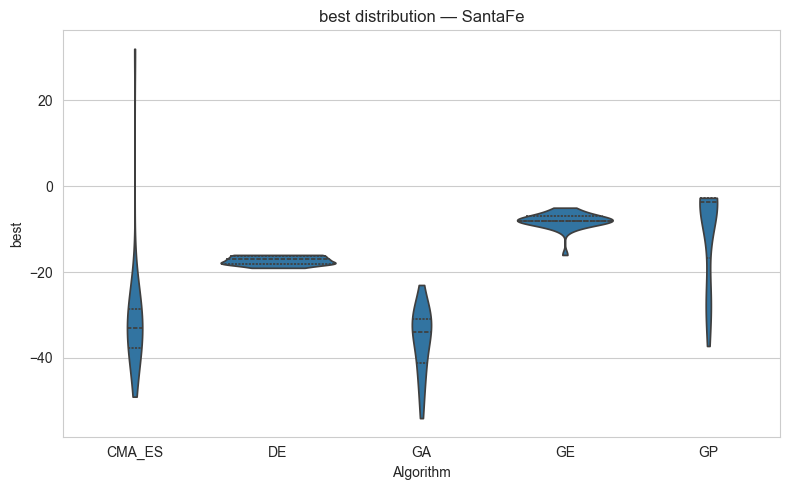

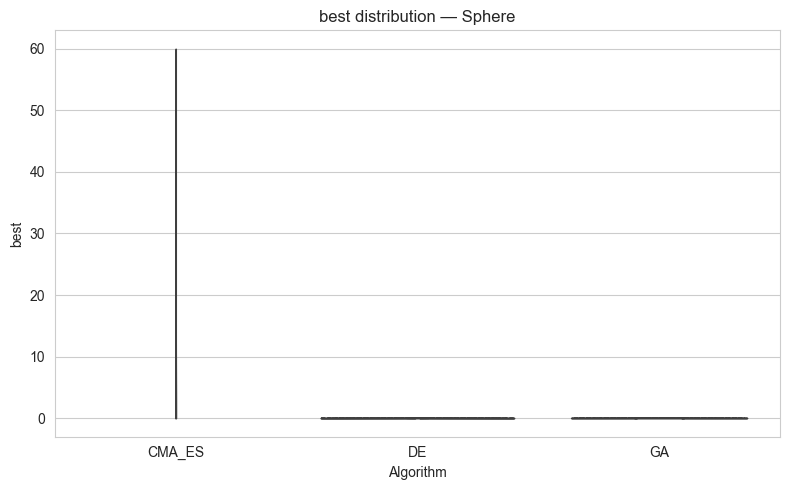

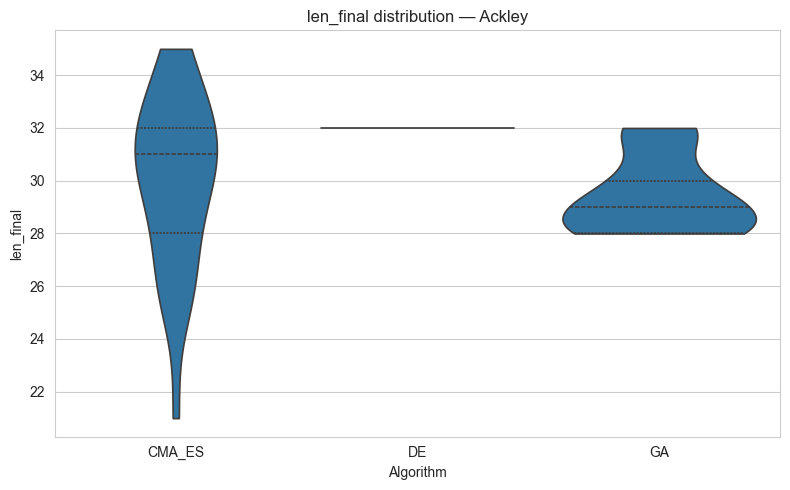

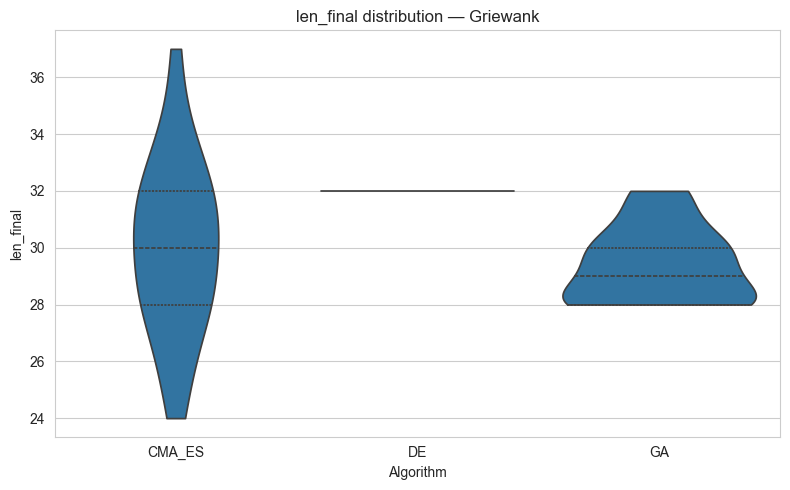

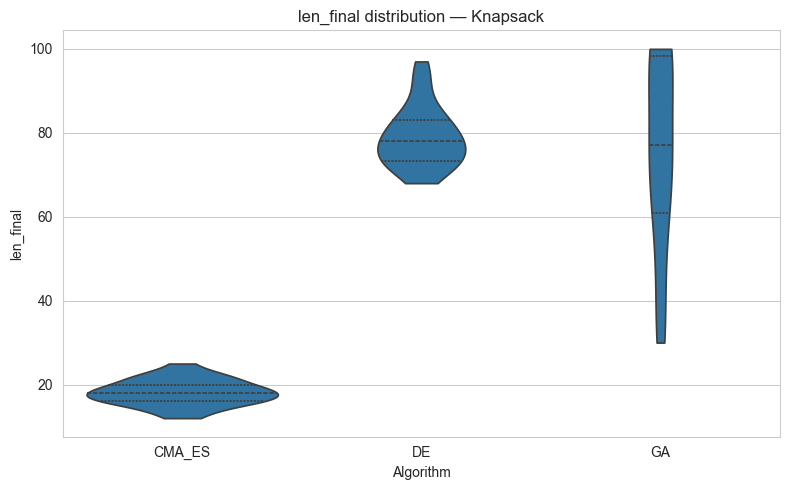

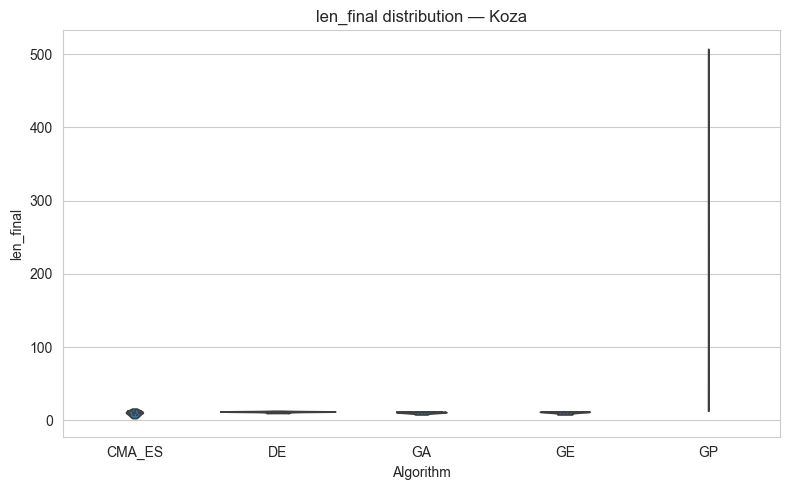

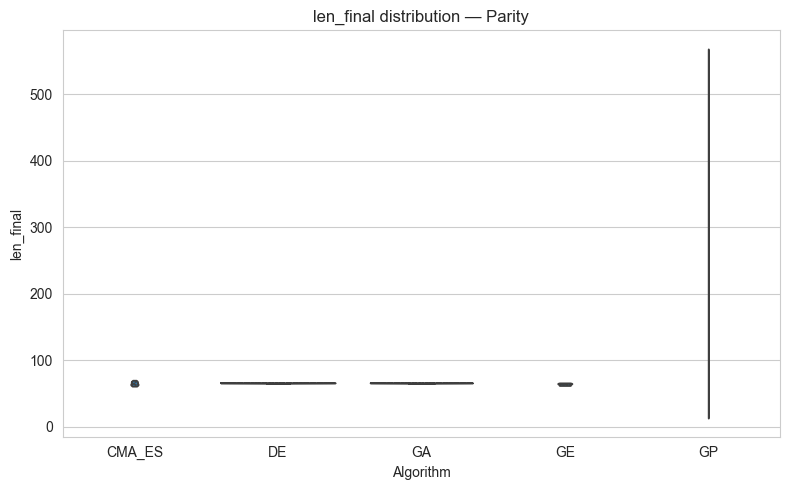

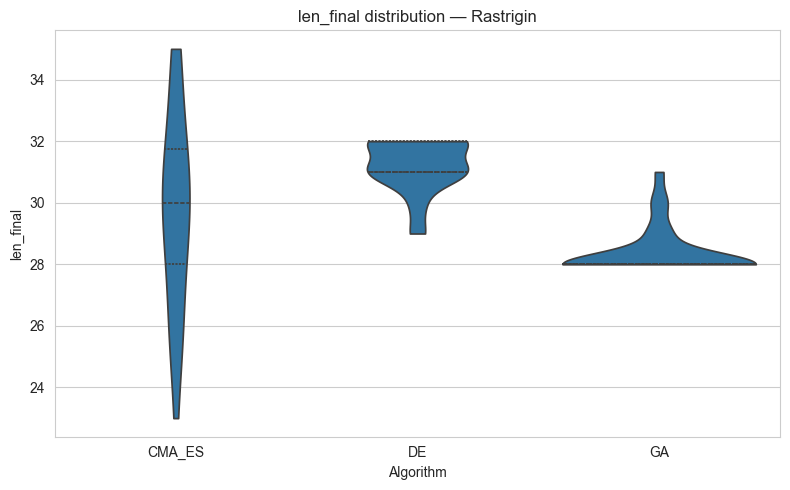

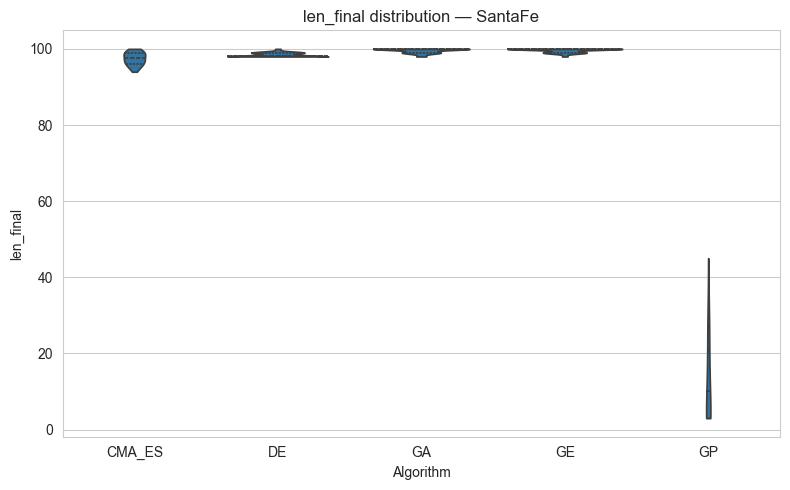

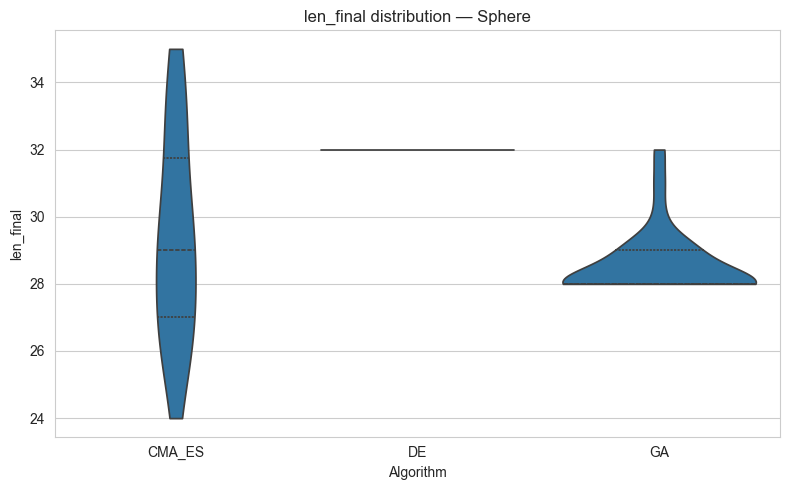

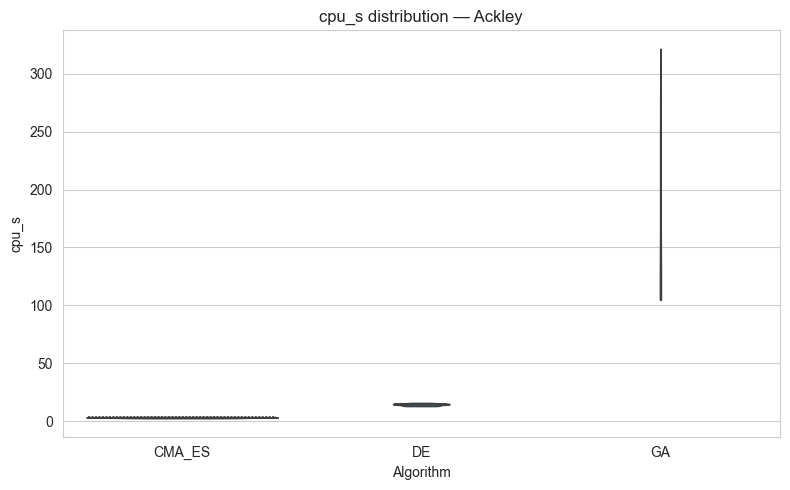

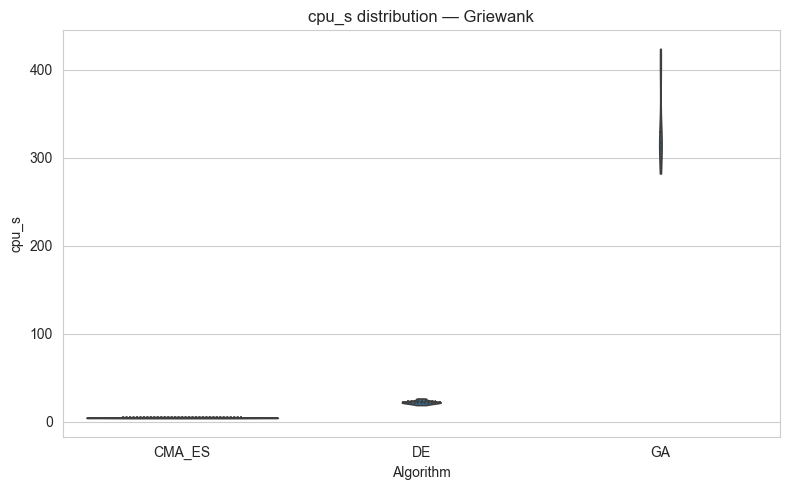

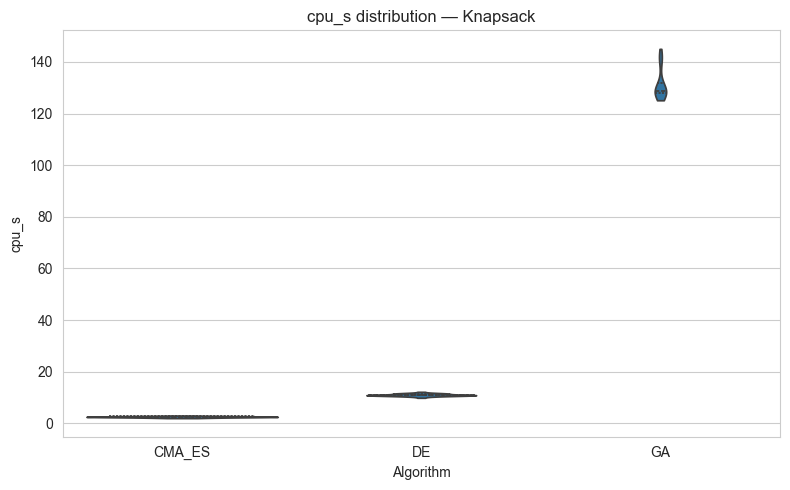

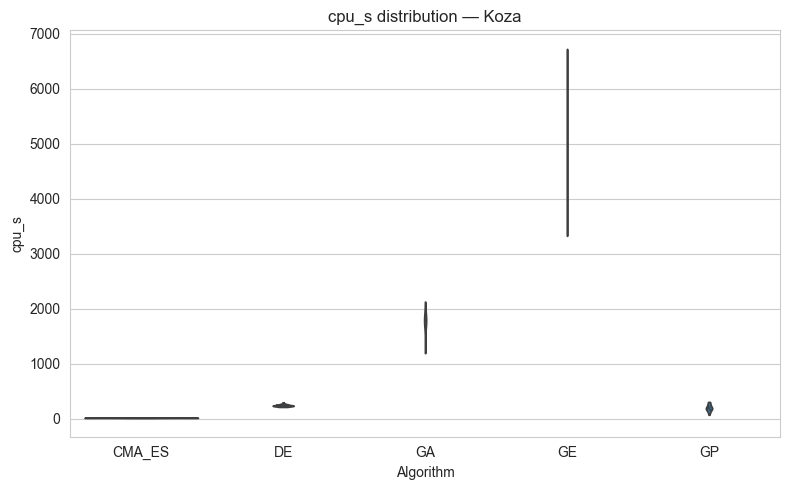

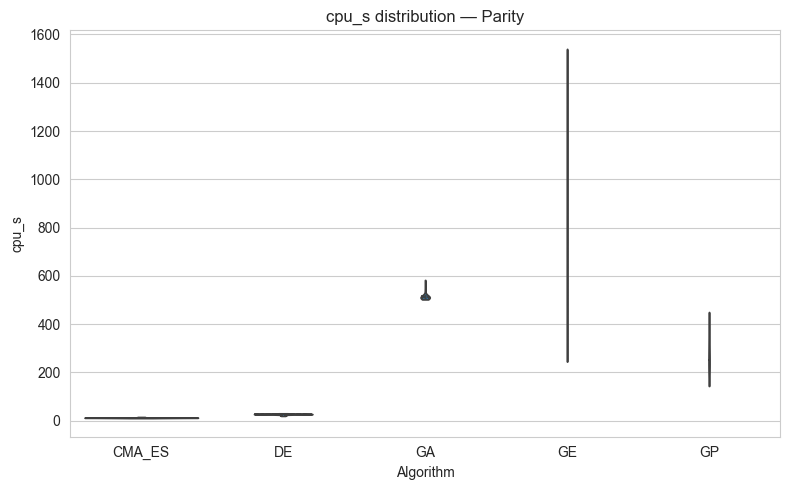

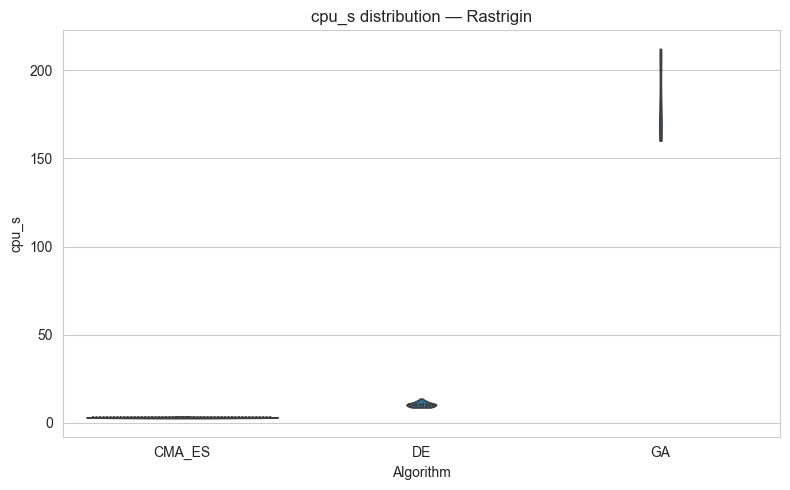

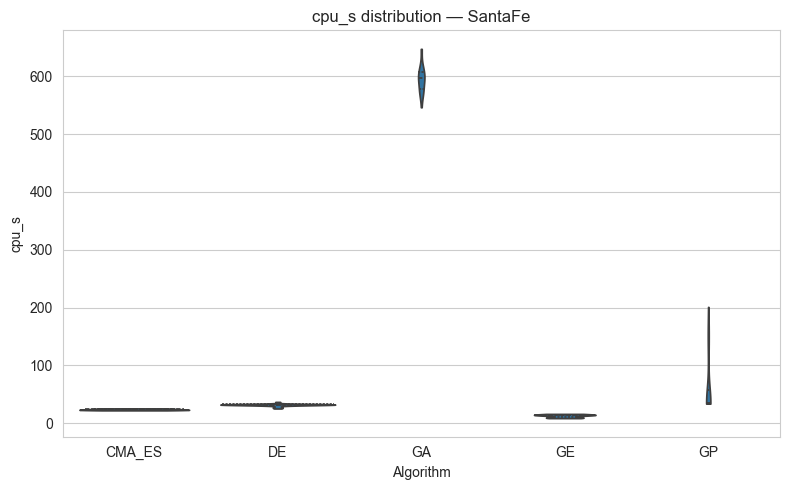

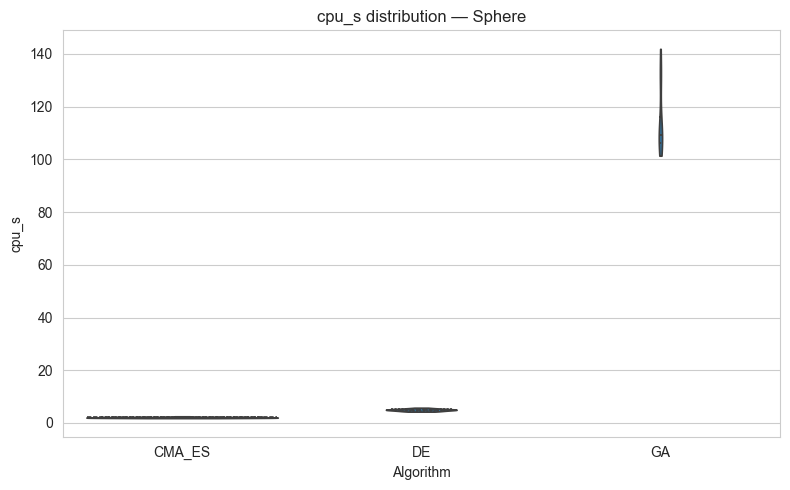

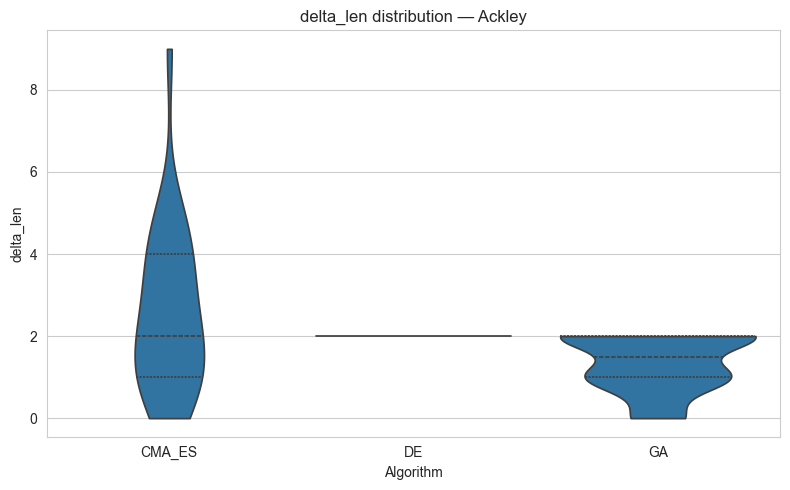

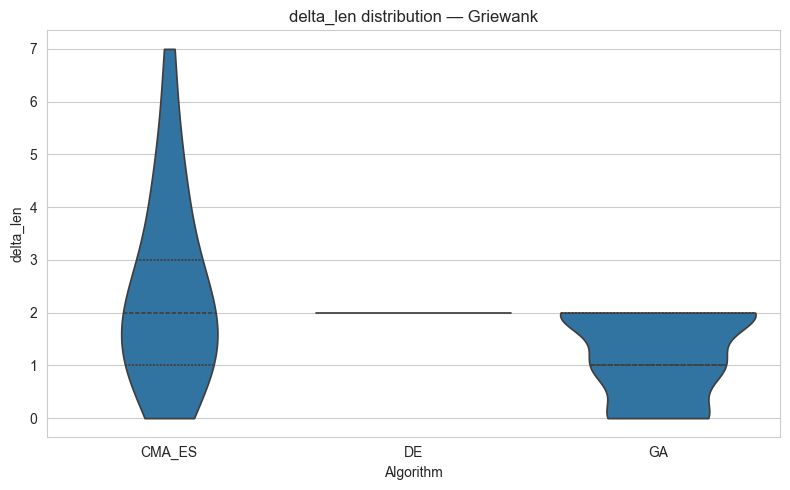

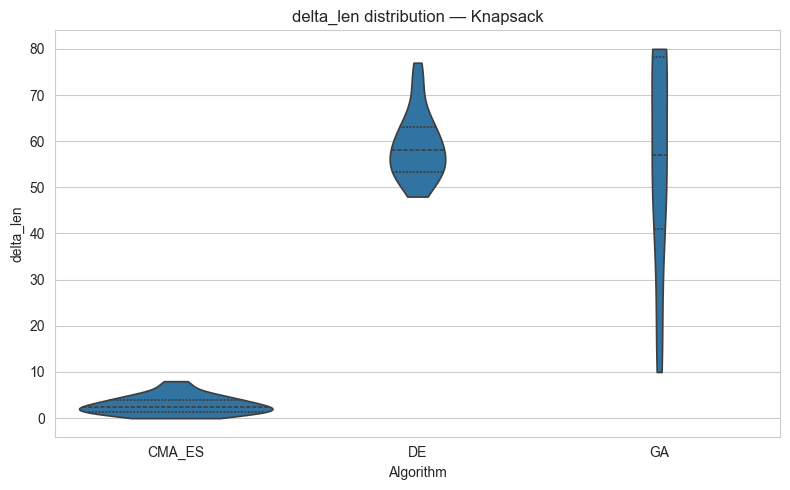

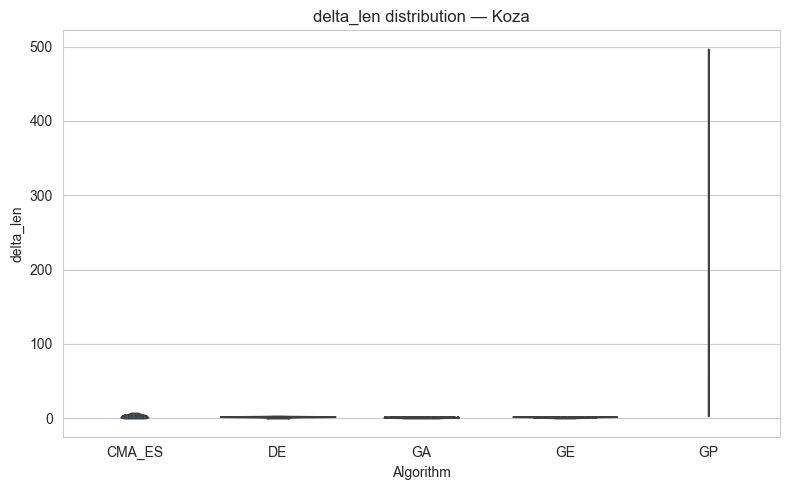

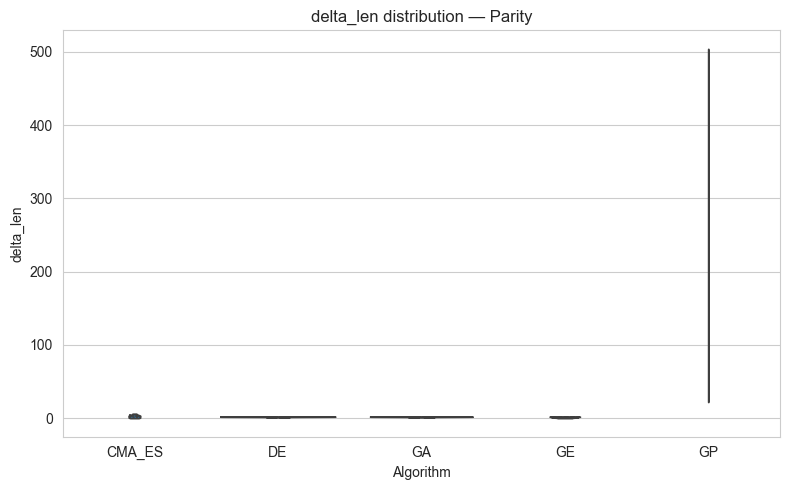

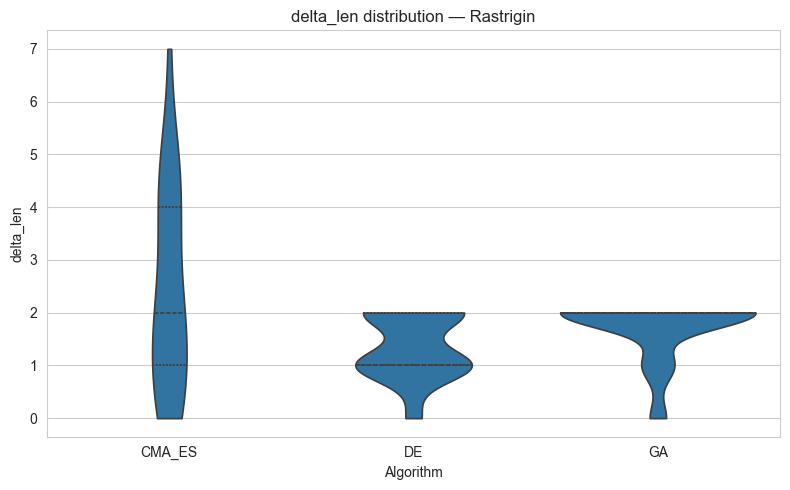

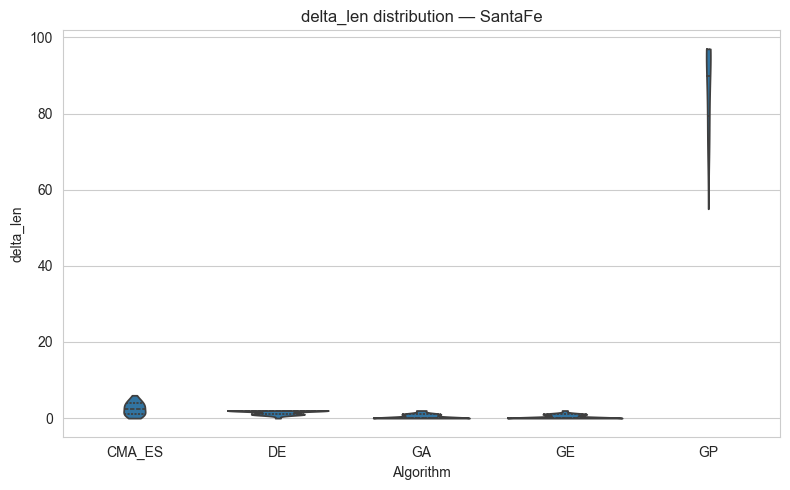

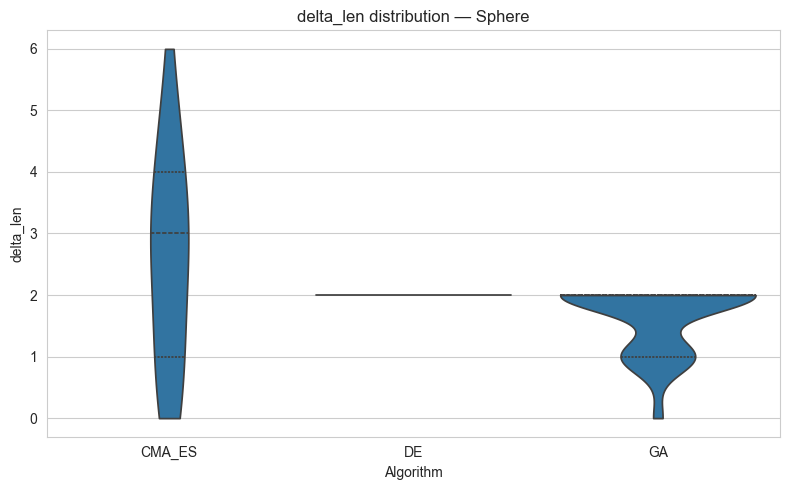

In [18]:
for m in metrics:
    for bench, sub in results.groupby('benchmark'):
        plt.figure(figsize=(8,5))
        sns.violinplot(x='algorithm', y=m, data=sub,
                       inner='quartile', cut=0)
        plt.title(f'{m} distribution — {bench}')
        plt.xlabel('Algorithm')
        plt.ylabel(m)
        plt.tight_layout()
        plt.show()

In [19]:
friedman_rows = []

posthoc_dir = 'posthoc_csv'
os.makedirs(posthoc_dir, exist_ok=True)

for metric in metrics:
    for bench, sub in results.groupby('benchmark'):
        data = [g[metric].values for _, g in sub.groupby('algorithm')]
        stat, p = sstats.friedmanchisquare(*data)
        friedman_rows.append({
            'benchmark': bench,
            'metric':      metric,
            'friedman_stat': stat,
            'p_value':     p
        })
        if p < 0.05:
            pivot = sub.pivot(
                index='replicate',
                columns='algorithm',
                values=metric
            )
            nemenyi = sp.posthoc_nemenyi_friedman(pivot)
            fname = f'posthoc_{bench}_{metric}.csv'
            path = os.path.join(posthoc_dir, fname)
            nemenyi.to_csv(path)
            print(f' Results written: {path}')

friedman_df = pd.DataFrame(friedman_rows)
friedman_df.to_csv('friedman_stats.csv', index=False)
print('Results written: friedman_stats.csv')

 Results written: posthoc_csv\posthoc_Ackley_best.csv
 Results written: posthoc_csv\posthoc_Griewank_best.csv
 Results written: posthoc_csv\posthoc_Knapsack_best.csv
 Results written: posthoc_csv\posthoc_Koza_best.csv
 Results written: posthoc_csv\posthoc_Parity_best.csv
 Results written: posthoc_csv\posthoc_Rastrigin_best.csv
 Results written: posthoc_csv\posthoc_SantaFe_best.csv
 Results written: posthoc_csv\posthoc_Sphere_best.csv
 Results written: posthoc_csv\posthoc_Ackley_len_final.csv
 Results written: posthoc_csv\posthoc_Griewank_len_final.csv
 Results written: posthoc_csv\posthoc_Knapsack_len_final.csv
 Results written: posthoc_csv\posthoc_Koza_len_final.csv
 Results written: posthoc_csv\posthoc_Parity_len_final.csv
 Results written: posthoc_csv\posthoc_Rastrigin_len_final.csv
 Results written: posthoc_csv\posthoc_SantaFe_len_final.csv
 Results written: posthoc_csv\posthoc_Sphere_len_final.csv
 Results written: posthoc_csv\posthoc_Ackley_cpu_s.csv
 Results written: posthoc_csv

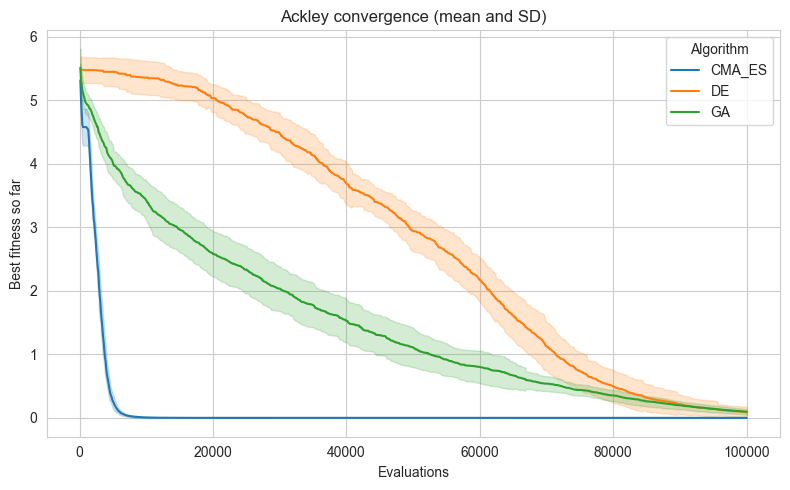

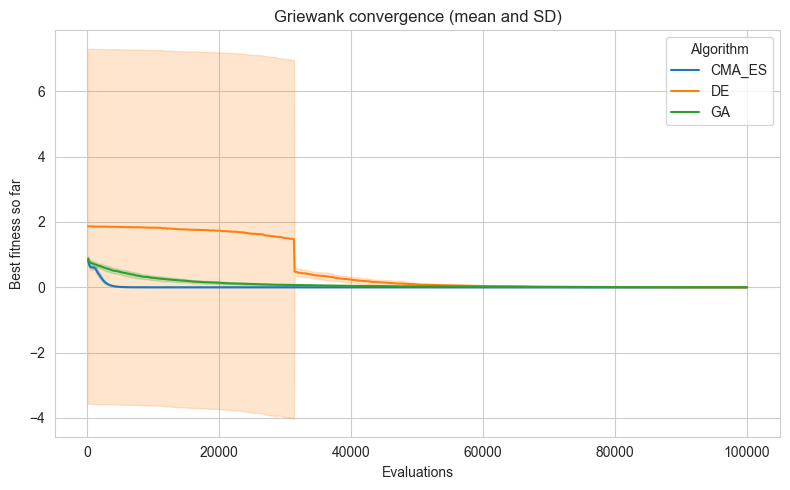

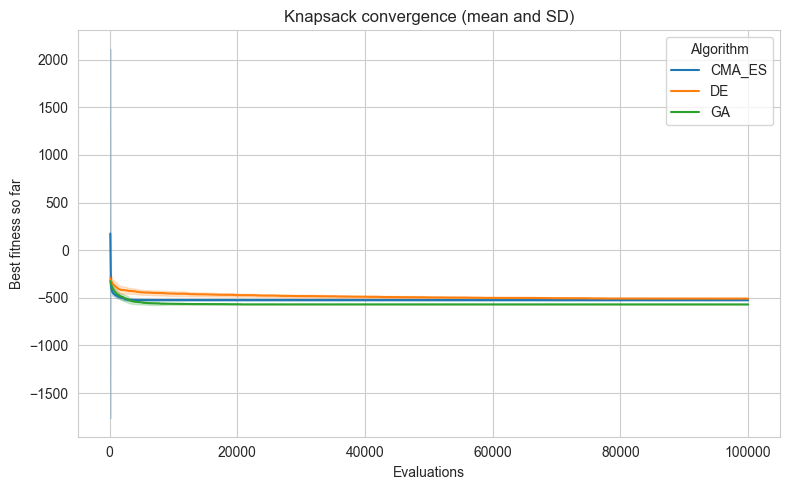

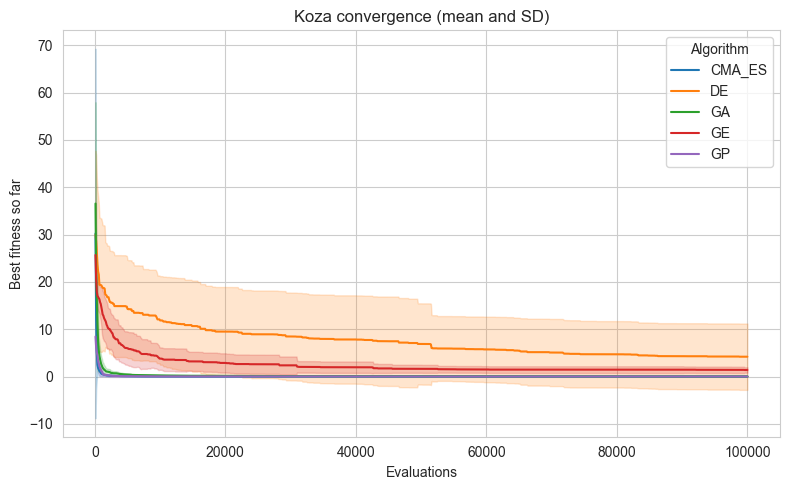

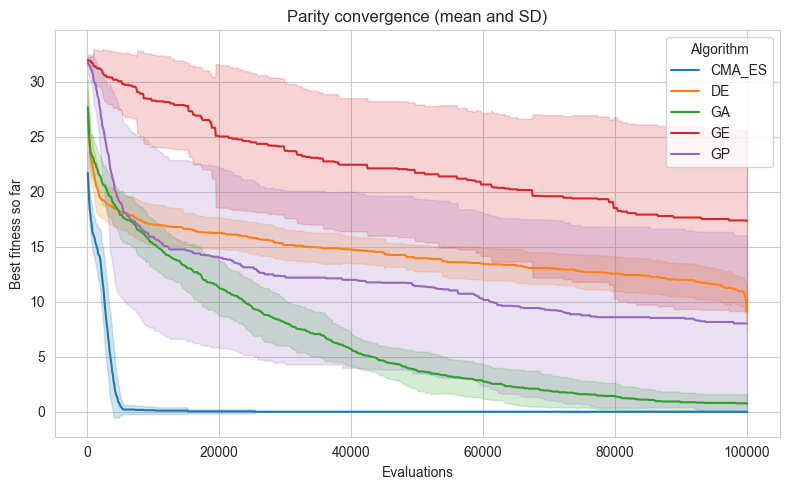

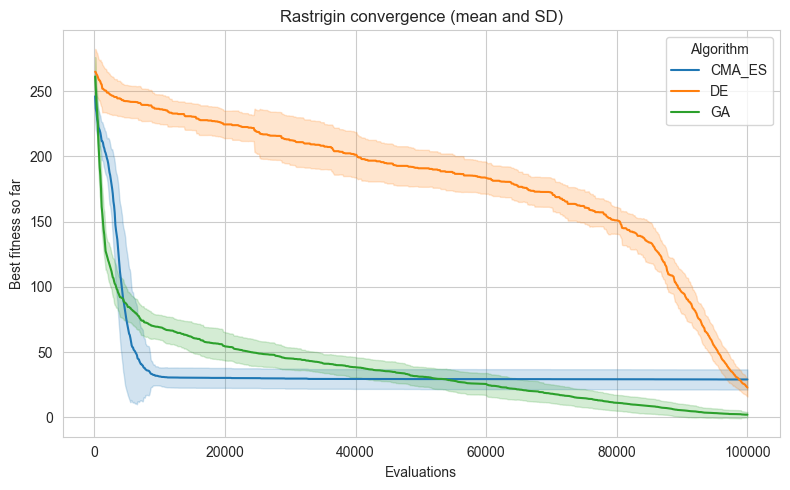

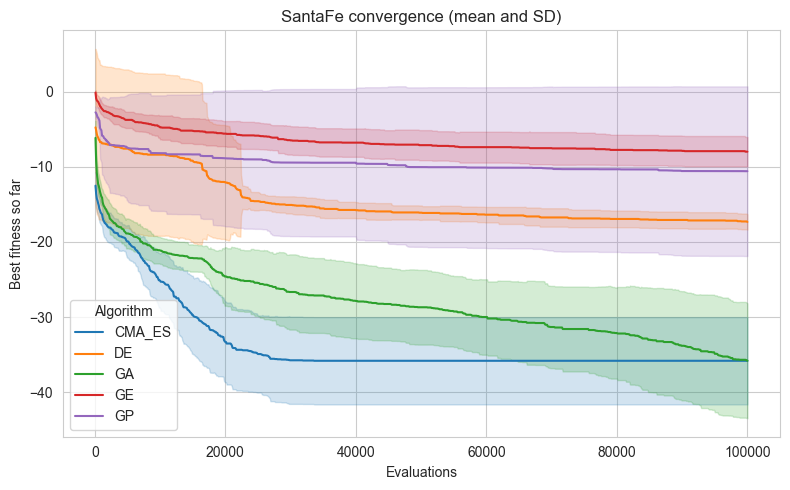

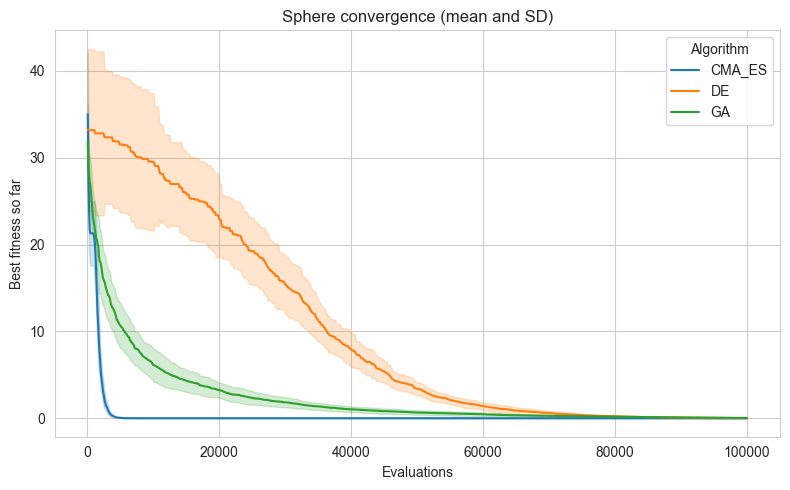

In [21]:
for bench, sub in history.groupby('benchmark'):
    plt.figure(figsize=(8,5))
    sns.lineplot(
        data=sub,
        x='evals', y='best_so_far',
        hue='algorithm',
        estimator='mean', errorbar='sd'
    )
    plt.title(f'{bench} convergence (mean and SD)')
    plt.xlabel('Evaluations')
    plt.ylabel('Best fitness so far')
    plt.legend(title='Algorithm')
    plt.tight_layout()
    plt.show()